In [1]:
import pandas as pd
import numpy as np
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.style as st

# Media Coverage Analysis - Occurences
In this notebook, we retrieve all the quotations from the Quotebank datasets (2012, 2016 and 2020) that originate from the following three newspapers: NYTimes, Fox News, BBC. 

We then parse for each of these newspapers: we check whether the quotations include the president candidates (and their running mates) names for each election. Finally, we build timelines of these keywords occurences for each of the three aforementioned newspapers in the months leading to the presidential elections in 2012, 2016 and 2020 (January - November)

## Part 1: Parse the Data per Newspaper
This part of the notebook parses the whole quotebank datasets for the years 2012, 2016 and 2020 based on the occurences of keywords of interest in the quotation, url and speaker columns of the dataset. Of course, we also focus on the origin of the quotations - whether they originate from any of the three newspapers of interest (information found in the urls column). 

This is the part of the assignment that takes the longest to run since we iterate over each of the three quotebank data sets (2012, 2016, 2020). To manage the memory constraints associated with this task, we always only load chunks of 100000 entries in our dataframe that we then process before loading the next chunk. Since the quotations are independent of one another, we can process the data in parts rather than loading everything into main memory.

Therefore, we load 100000 quotations, parse them based on their origin (do they come from articles from nytimes, foxnews or bbc) and then further parse them based on the occurence of candidate names in the quotation, url or speaker name. In short, we only keep quotations that come from one of the three newspapers and that involves a candidate or its running mate. 

Once we parse this information, we will be left with a much smaller dataset that we can store in a csv file. This allows us to then only load those csv files for further parts of the project rather than recomputing this memory and time intensive task. Thus, the whole quotebank quotation parsing will only be performed once. 

In [50]:
# Method to check if a speaker is the list of candidates. 
def check_speaker(speaker, keywords):
    x = re.search(keywords, speaker, re.I)
    return True if x else False

In [51]:
# Method to check if a keyword occurs in a list of urls. 
def check_urls(urls, keywords):
    for url in urls:
        x = re.search(keywords, url, re.I)
        if x: return True
    return False

In [52]:
# Method to process a dataframe based on the keywords we are looking for. 
def process_keywords(df, date):
    if date == "2016":
        keywords = "Clinton|Kaine|Trump|Pence"
    elif date == "2020": 
        keywords = "Biden|Harris|Trump|Pence"
    else: 
        keywords = "Obama|Romney|Biden|Ryan"
    df_parsed = df[df["quotation"].str.contains(keywords, regex=True, case=False) 
                             | df['urls'].apply(lambda x: check_urls(x,keywords))
                             | df['speaker'].apply(lambda x: check_speaker(x,keywords))]
    #print(df_parsed)
    return df_parsed

In [53]:
# Method to process dataframes read from the Quotebank dataset.
def process_dataframes(chunk, year):
    # First we filter the dates of the quotebanks quotations to only keep interval of interest
    if year=="2016":
        day = "08" 
    elif year=="2020":
        day = "03"
    else:
        day = "06"
    # Filter dates to only keep quotations on interval January - November
    dates_filtered_df = chunk.loc[(chunk['date'] >= f'{year}-01-01')
                     & (chunk['date'] < f'{year}-11-{day}')]
    # Filter our three dataframes based the origin of the respective newspapers.
    df_nytimes_all =  dates_filtered_df[dates_filtered_df["urls"].apply(lambda x: check_urls(x,"nytimes.com"))]
    df_fox_all =  dates_filtered_df[dates_filtered_df["urls"].apply(lambda x: check_urls(x,"foxnews.com"))]
    df_bbc_all =  dates_filtered_df[dates_filtered_df["urls"].apply(lambda x: check_urls(x,"bbc.co.uk"))]
    # Now we want to filter each df based on the occurence of keywords in the quotations and urls
    df_nytimes_keywords = process_keywords(df_nytimes_all, date)
    df_fox_keywords = process_keywords(df_fox_all, date)
    df_bbc_keywords = process_keywords(df_bbc_all, date)
    return df_nytimes_keywords, df_nytimes_all, df_fox_keywords, df_fox_all, df_bbc_keywords, df_bbc_all

In [55]:
PATH="Data/"
dates = ["2012", "2016", "2020"]

for date in dates:
    print(f"Processing Year: {date}")
    # Read the quotebank files for 2012, 2016 and 2020
    with pd.read_json(f'Quotebank/quotes-{date}.json.bz2', 
                      lines=True, compression='bz2', chunksize=100000) as df_reader:
            i = 0
            # Process the data in chunks
            for chunk in df_reader:
                if (i*100000)%2000000 == 0:
                    print(f"Processed: {i*100000} quotations")
                # Call the main processing dataframe
                df_nytimes_keywords, df_nytimes_all, df_fox_keywords, df_fox_all, df_bbc_keywords, df_bbc_all = process_dataframes(chunk, date)
                # Store the processed data into csv for future use
                # NOTE: we also want to store csv files of ALL the NYTimes, BBC, Fox News quotations.
                # This will allow us to perform further analysis in later sections of this notebook. 
                if i == 0:
                    df_nytimes_keywords.to_csv(f'{PATH}{date}/ny_times_keywords_{date}.csv')
                    df_nytimes_all.to_csv(f'{PATH}{date}/ny_times_{date}.csv')
                    df_fox_keywords.to_csv(f'{PATH}{date}/foxnews_keywords_{date}.csv')
                    df_fox_all.to_csv(f'{PATH}{date}/foxnews_{date}.csv')
                    df_bbc_keywords.to_csv(f'{PATH}{date}/bbc_keywords_{date}.csv')
                    df_bbc_all.to_csv(f'{PATH}{date}/bbc_{date}.csv')
                else:
                    df_nytimes_keywords.to_csv(f'{PATH}{date}/ny_times_keywords_{date}.csv', 
                                               mode='a', header=False)
                    df_nytimes_all.to_csv(f'{PATH}{date}/ny_times_{date}.csv', mode='a', header=False)
                    df_fox_keywords.to_csv(f'{PATH}{date}/foxnews_keywords_{date}.csv', mode='a', header=False)
                    df_fox_all.to_csv(f'{PATH}{date}/foxnews_{date}.csv', mode='a', header=False)
                    df_bbc_keywords.to_csv(f'{PATH}{date}/bbc_keywords_{date}.csv', mode='a', header=False)
                    df_bbc_all.to_csv(f'{PATH}{date}/bbc_{date}.csv', mode='a', header=False)
                i += 1

Processing Year: 2012
Processed: 0 quotations
Processed: 2000000 quotations
Processed: 4000000 quotations
Processed: 6000000 quotations
Processed: 8000000 quotations
Processed: 10000000 quotations
Processed: 12000000 quotations
Processed: 14000000 quotations
Processed: 16000000 quotations
Processed: 18000000 quotations
Processing Year: 2016
Processed: 0 quotations
Processed: 2000000 quotations
Processed: 4000000 quotations
Processed: 6000000 quotations
Processed: 8000000 quotations
Processed: 10000000 quotations
Processed: 12000000 quotations
Processing Year: 2020
Processed: 0 quotations
Processed: 2000000 quotations
Processed: 4000000 quotations


## Part 2: Aggregate the quotations on a monthly basis
In this part we want to do some analysis regarding the number of mentions per month for each newspaper that we have retrieved when parsing the data in Part 1. This part will not focus on the candidates but rather on the occurences per newspaper. It will already give us an idea if the newspapers are equally represented in our quotebank dataset for the years 2012, 2016 and 2020 and how much they mentioned political candidates during the election (independently of the candidates). 

In [5]:
# First we read the data processed in Part 1 and stored as zipped csv files (see the files in the github repo)

#2012
nytimes_2012_df = pd.read_csv("Data/2012/ny_times_keywords_2012.zip", compression="zip")
nytimes_2012_all_df = pd.read_csv("Data/2012/ny_times_2012.zip", compression="zip")

fox_2012_df = pd.read_csv("Data/2012/foxnews_keywords_2012.zip", compression="zip")
fox_2012_all_df = pd.read_csv("Data/2012/foxnews_2012.zip", compression="zip")

bbc_2012_df = pd.read_csv("Data/2012/bbc_keywords_2012.zip", compression="zip")
bbc_2012_all_df = pd.read_csv("Data/2012/bbc_2012.zip", compression="zip")

#2016
nytimes_2016_df = pd.read_csv("Data/2016/ny_times_keywords_2016.zip", compression="zip")
nytimes_2016_all_df = pd.read_csv("Data/2016/ny_times_2016.zip", compression="zip")

fox_2016_df = pd.read_csv("Data/2016/foxnews_keywords_2016.zip", compression="zip")
fox_2016_all_df = pd.read_csv("Data/2016/foxnews_2016.zip", compression="zip")

bbc_2016_df = pd.read_csv("Data/2016/bbc_keywords_2016.zip", compression="zip")
bbc_2016_all_df = pd.read_csv("Data/2016/bbc_2016.zip", compression="zip")

# 2020
nytimes_2020_df = pd.read_csv("Data/2020/ny_times_keywords_2020.zip", compression="zip")
nytimes_2020_all_df = pd.read_csv("Data/2020/ny_times_2020.zip", compression="zip")

fox_2020_df = pd.read_csv("Data/2020/foxnews_keywords_2020.zip", compression="zip")
fox_2020_all_df = pd.read_csv("Data/2020/foxnews_2020.zip", compression="zip")

bbc_2020_df = pd.read_csv("Data/2020/bbc_keywords_2020.zip", compression="zip")
bbc_2020_all_df = pd.read_csv("Data/2020/bbc_2020.zip", compression="zip")

In [6]:
# We want to format the date representation for each dataframe

# Format time for 2012
nytimes_2012_df['date'] = pd.to_datetime(nytimes_2012_df['date'])
nytimes_2012_all_df['date'] = pd.to_datetime(nytimes_2012_all_df['date'])

fox_2012_df['date'] = pd.to_datetime(fox_2012_df['date'])
fox_2012_all_df['date'] = pd.to_datetime(fox_2012_all_df['date'])

bbc_2012_df['date'] = pd.to_datetime(bbc_2012_df['date'])
bbc_2012_all_df['date'] = pd.to_datetime(bbc_2012_all_df['date'])

# Format time for 2016
nytimes_2016_df['date'] = pd.to_datetime(nytimes_2016_df['date'])
nytimes_2016_all_df['date'] = pd.to_datetime(nytimes_2016_all_df['date'])

fox_2016_df['date'] = pd.to_datetime(fox_2016_df['date'])
fox_2016_all_df['date'] = pd.to_datetime(fox_2016_all_df['date'])

bbc_2016_df['date'] = pd.to_datetime(bbc_2016_df['date'])
bbc_2016_all_df['date'] = pd.to_datetime(bbc_2016_all_df['date'])

# Format time for 2020
nytimes_2020_df['date'] = pd.to_datetime(nytimes_2020_df['date'])
nytimes_2020_all_df['date'] = pd.to_datetime(nytimes_2020_all_df['date'])

fox_2020_df['date'] = pd.to_datetime(fox_2020_df['date'])
fox_2020_all_df['date'] = pd.to_datetime(fox_2020_all_df['date'])

bbc_2020_df['date'] = pd.to_datetime(bbc_2020_df['date'])
bbc_2020_all_df['date'] = pd.to_datetime(bbc_2020_all_df['date'])

In [7]:
# We need to add the origin of each quotation in the dataframe (used for visualization)

# Add additional column information for plotting 2012
nytimes_2012_df['month'] = nytimes_2012_df['date'].dt.strftime('%b')
nytimes_2012_all_df['month'] = nytimes_2012_all_df['date'].dt.strftime('%b')
nytimes_2012_df['type'] = "NY Times"

fox_2012_df['month'] = fox_2012_df['date'].dt.strftime('%b')
fox_2012_all_df['month'] = fox_2012_all_df['date'].dt.strftime('%b')
fox_2012_df['type'] = "Fox News"

bbc_2012_df['month'] = bbc_2012_df['date'].dt.strftime('%b')
bbc_2012_all_df['month'] = bbc_2012_all_df['date'].dt.strftime('%b')
bbc_2012_df['type'] = "BBC"

# Add additional column information for plotting 2016
nytimes_2016_df['month'] = nytimes_2016_df['date'].dt.strftime('%b')
nytimes_2016_all_df['month'] = nytimes_2016_all_df['date'].dt.strftime('%b')
nytimes_2016_df['type'] = "NY Times"

fox_2016_df['month'] = fox_2016_df['date'].dt.strftime('%b')
fox_2016_all_df['month'] = fox_2016_all_df['date'].dt.strftime('%b')
fox_2016_df['type'] = "Fox News"

bbc_2016_df['month'] = bbc_2016_df['date'].dt.strftime('%b')
bbc_2016_all_df['month'] = bbc_2016_all_df['date'].dt.strftime('%b')
bbc_2016_df['type'] = "BBC"

# Add additional column information for plotting 2020
nytimes_2020_df['month'] = nytimes_2020_df['date'].dt.strftime('%b')
nytimes_2020_all_df['month'] = nytimes_2020_all_df['date'].dt.strftime('%b')
nytimes_2020_df['type'] = "NY Times"

fox_2020_df['month'] = fox_2020_df['date'].dt.strftime('%b')
fox_2020_all_df['month'] = fox_2020_all_df['date'].dt.strftime('%b')
fox_2020_df['type'] = "Fox News"

bbc_2020_df['month'] = bbc_2020_df['date'].dt.strftime('%b')
bbc_2020_all_df['month'] = fox_2020_all_df['date'].dt.strftime('%b')
bbc_2020_df['type'] = "BBC"

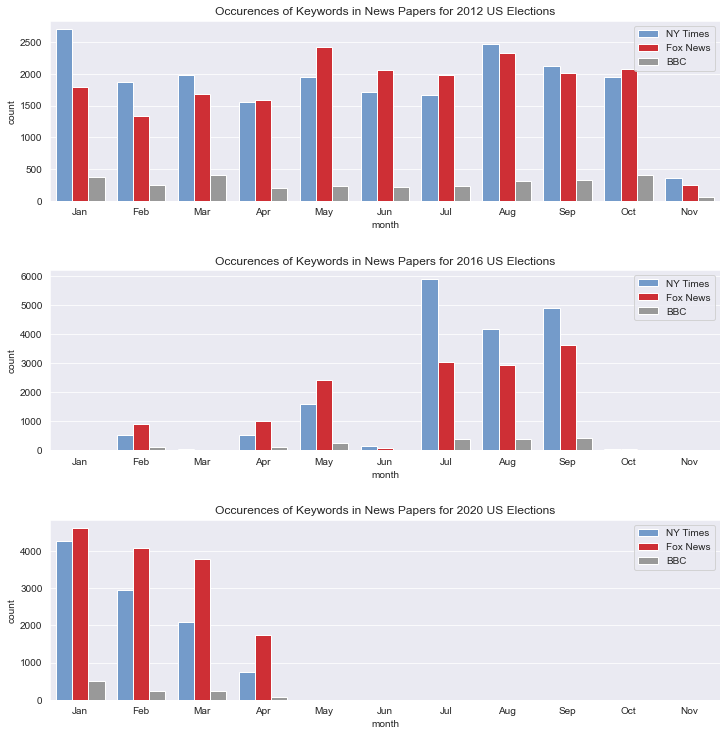

In [8]:
# Plotting code

Labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Total', 
          'Mean', 'Median', 'std', 'Max']
df_2012 = pd.concat([nytimes_2012_df, fox_2012_df,bbc_2012_df], ignore_index=True)
df_2016 = pd.concat([nytimes_2016_df, fox_2016_df,bbc_2016_df], ignore_index=True)
df_2020 = pd.concat([nytimes_2020_df, fox_2020_df,bbc_2020_df], ignore_index=True)


sns.set_style("darkgrid")
fig, axs = plt.subplots(3,figsize=(10,10))
fig.tight_layout(h_pad=5)

axs[0].set_title("Occurences of Keywords in News Papers for 2012 US Elections")
sns.countplot(x="month",hue="type",data=df_2012,order=Labels[:11], ax=axs[0], palette=['#6699d8',"#e9141d","#999999"])
axs[0].legend(loc='upper right')

axs[1].set_title("Occurences of Keywords in News Papers for 2016 US Elections")
sns.countplot(x="month",hue="type",data=df_2016,order=Labels[:11], ax=axs[1], palette=['#6699d8',"#e9141d","#999999"])
axs[1].legend(loc='upper right')

axs[2].set_title("Occurences of Keywords in News Papers for 2020 US Elections")
sns.countplot(x="month",hue="type",data=df_2020,order=Labels[:11], ax=axs[2], palette=['#6699d8',"#e9141d","#999999"])
axs[2].legend(loc='upper right');

This first visualization gives us several important insights: 
* **First**: the data for the 2012 elections that we retrieved is fairly well represented with generally more mentions in the NY Times, somewhat closely followed by Fox News and finally by BBC which (as expected) has the least mentions- we believe that BBC should have the least mentions because first it isn't a natively american newspaper, second it is generally regarded as a more "centrist" newspaper - in contrast to NY Times that is generally more democrat leaning and Fox News that is republican leaning. 

* **Second**: we are missing a considerable amount of data for the months of January-June and October in 2016. This could potentially mean that there are only very little mentions in the newspapers we target (which seems highly unlikely considering the general fuss in the months leading to the elections and by comparing it with the 2012 data retrieved). A more plausible explanation could refer to the quality of the Quotebank dataset, simply missing relevant quotations in these 7 months. We perform further study below regarding the overall number of quotations retrieved from quotebank in 2012, 2016 and 2020 (context independent) from these newspapers. This should give us a bit more insight on the observed behavior. We may need to augment the data by estimating plausible values based on the overall mean number of quotations retrieved for 2016 or simply by trying to find some external information (note that this method will be an issue when performing text sentiment analysis since we are missing the actual quotations)

* **Third**: the data in the 2020 stops in April. This is highly problematic for our study as the data simply does not exist in the quotebank dataset for any months after April 2020. Therefore, we consider it a bad idea to enrich this set as it would lead to very arbitrary results. We may be able to find external information relating to the number of occurences but this method will fall short when performing text sentiment analysis since we are missing actual quotations. Ultimately, we may have to drop the 2020 dataset from our study. However, once the study is performed on 2012 and 2016, it will be very easy to apply it to 2020 as well once we have more data on it (future project maybe?)


In [9]:
def build_statistic_df(df_keywords, df_all, date):
    df1 = df_keywords.value_counts(["month"]).to_frame(f"quote_kw_{date}")
    df2 = df_all.value_counts(["month"]).to_frame(f"quote_total_{date}")
    df_total = pd.merge(df1, df2, left_index=True, right_index=True, how='outer')
    df_total.loc['Total',:]= df_total.sum(axis=0).values
    df_total = df_total.astype({f"quote_kw_{date}": 'int64',f"quote_total_{date}":'int64'})
    df_total[f'%_{date}'] = (df_total[f"quote_kw_{date}"]/df_total[f"quote_total_{date}"])*100
    df_total.loc['Mean',:]= df_total.mean(axis=0).values
    df_total.loc['Median',:]= df_total.median(axis=0).values
    df_total.loc['std',:]= df_total.std(axis=0).values
    df_total.loc['Max',:]= df_total.max(axis=0).values
    df_total.index.rename('Period', inplace=True)
    return df_total

def merge_dataframes(df1, df2, df3):
    df_total_temp = pd.merge(df1, df2, left_index=True, right_index=True, how='outer')
    df_total = pd.merge(df_total_temp, df3, left_index=True, right_index=True, how='outer')
    return df_total

### **New York Times**

In [10]:
# We generate a dataframe that compares the counts of newspapers for the years 2012, 2016, 2020
df_stat_2012 = build_statistic_df(nytimes_2012_df, nytimes_2012_all_df, 2012)
df_stat_2016 = build_statistic_df(nytimes_2016_df, nytimes_2016_all_df, 2016)
df_stat_2020 = build_statistic_df(nytimes_2020_df, nytimes_2020_all_df, 2020)

df_total = merge_dataframes(df_stat_2012, df_stat_2016, df_stat_2020)

df_total.fillna(0,inplace=True)
df_total = df_total.reindex(axis='index', level=0, labels=Labels)
df_total

,quote_kw_2012,quote_total_2012,%_2012,quote_kw_2016,quote_total_2016,%_2016,quote_kw_2020,quote_total_2020,%_2020
Period,,,,,,,,,
Jan,2700.000000,21079.000000,12.808957,26.000000,158.000000,16.455696,4278.000000,17372.000000,24.625835
Feb,1876.000000,19901.000000,9.426662,519.000000,3568.000000,14.545964,2965.000000,13066.000000,22.692484
Mar,1988.000000,21712.000000,9.156227,34.000000,53.000000,64.150943,2092.000000,9914.000000,21.101473
Apr,1560.000000,19446.000000,8.022215,518.000000,3428.000000,15.110852,749.000000,4859.000000,15.414694
May,1952.000000,20504.000000,9.520094,1591.000000,7956.000000,19.997486,0.000000,0.000000,0.000000
Jun,1710.000000,18719.000000,9.135103,142.000000,1422.000000,9.985935,0.000000,0.000000,0.000000
Jul,1664.000000,15936.000000,10.441767,5915.000000,40144.000000,14.734456,0.000000,0.000000,0.000000
Aug,2478.000000,16648.000000,14.884671,4179.000000,36270.000000,11.521919,0.000000,0.000000,0.000000
Sep,2127.000000,13266.000000,16.033469,4895.000000,39730.000000,12.320664,0.000000,0.000000,0.000000


The information displayed in the table above confirms some of the intuition developped in via the visualization. First, it seems clear that the quotebank dataset is unbalanced when focusing on certain months in 2016. In January 2016, we only had 26 NYTimes quotes that related to a presidential candidate while the quotebank dataset itself only has 158 quotations for the NYTimes. Even worse for the month of March where we have 34 quotations with keywords for only 53 quotations from NYTimes in total. This is in sharp contrast with the months of July, August, September that include several thousands of quotations. 

On the other hand, we note that the numbers from the 2012 elections are quite stable and show an average that about 11.5% of the quotebank quotations from NYTimes in 2012 related to the presidential candidates.

### **Fox News**

In [11]:
df_stat_2012 = build_statistic_df(fox_2012_df, fox_2012_all_df, 2012)
df_stat_2016 = build_statistic_df(fox_2016_df, fox_2016_all_df, 2016)
df_stat_2020 = build_statistic_df(fox_2020_df, fox_2020_all_df, 2020)
df_total = merge_dataframes(df_stat_2012, df_stat_2016, df_stat_2020)

df_total.fillna(0,inplace=True)
df_total = df_total.reindex(axis='index', level=0, labels=Labels)
df_total

,quote_kw_2012,quote_total_2012,%_2012,quote_kw_2016,quote_total_2016,%_2016,quote_kw_2020,quote_total_2020,%_2020
Period,,,,,,,,,
Jan,1797.000000,8418.000000,21.347113,13.000000,91.000000,14.285714,4609.000000,15748.000000,29.267209
Feb,1339.000000,7930.000000,16.885246,895.000000,4196.000000,21.329838,4086.000000,13865.000000,29.469888
Mar,1687.000000,7967.000000,21.174846,20.000000,37.000000,54.054054,3779.000000,14247.000000,26.524882
Apr,1594.000000,7144.000000,22.312430,1025.000000,5419.000000,18.914929,1747.000000,7102.000000,24.598705
May,2421.000000,11771.000000,20.567496,2413.000000,11375.000000,21.213187,0.000000,0.000000,0.000000
Jun,2069.000000,11312.000000,18.290311,67.000000,279.000000,24.014337,0.000000,0.000000,0.000000
Jul,1990.000000,9063.000000,21.957409,3034.000000,11512.000000,26.355108,0.000000,0.000000,0.000000
Aug,2328.000000,7692.000000,30.265211,2940.000000,12544.000000,23.437500,0.000000,0.000000,0.000000
Sep,2008.000000,7170.000000,28.005579,3621.000000,13929.000000,25.996123,0.000000,0.000000,0.000000


A similar behavior can be observed for the Fox News Magazine. Very little numbers for some months in 2016, which further validates the assumption that the quotebank dataset may be unbalanced for these particular months in 2016.  

Interestingly for 2012, we note that the average number of quotations in our dataset that relate to a political candidate is much higher than for the NYTimes (about 22.6% - twice as much as NYTimes). This may relate to the nature of the quotations retrieved by the quotebank dataset or by the fact that the NYTimes possibly covers a wider ranger of topics than Fox News. 

### **BBC**

In [12]:
df_stat_2012  = build_statistic_df(bbc_2012_df, bbc_2012_all_df, 2012)
df_stat_2016 = build_statistic_df(bbc_2016_df, bbc_2016_all_df, 2016)
df_stat_2020 = build_statistic_df(bbc_2020_df, bbc_2020_all_df, 2020)

df_total = merge_dataframes(df_stat_2012, df_stat_2016, df_stat_2020)

df_total.fillna(0,inplace=True)
df_total = df_total.astype({"quote_kw_2020": 'int64', "quote_total_2020": 'int64'})
df_total = df_total.reindex(axis='index', level=0, labels=Labels)
df_total

,quote_kw_2012,quote_total_2012,%_2012,quote_kw_2016,quote_total_2016,%_2016,quote_kw_2020,quote_total_2020,%_2020
Period,,,,,,,,,
Jan,379.000000,16398.000000,2.311257,2.000000,179.000000,1.117318,510,8049,6.336191
Feb,254.000000,14212.000000,1.787222,124.000000,5449.000000,2.275647,245,7082,3.459475
Mar,402.000000,14572.000000,2.758715,9.000000,13.000000,69.230769,231,7276,3.174821
Apr,205.000000,11602.000000,1.766937,122.000000,5642.000000,2.162354,72,3635,1.980743
May,242.000000,13257.000000,1.825451,258.000000,13054.000000,1.976406,0,0,0.000000
Jun,215.000000,12300.000000,1.747967,10.000000,333.000000,3.003003,0,0,0.000000
Jul,232.000000,12403.000000,1.870515,376.000000,13744.000000,2.735739,0,0,0.000000
Aug,318.000000,11700.000000,2.717949,393.000000,12471.000000,3.151311,0,0,0.000000
Sep,322.000000,11738.000000,2.743227,421.000000,13838.000000,3.042347,0,0,0.000000


The quotebank dataset contains much less data for the BBC newspaper than for the other two but still shows similar trends overall: somewhat stable values for 2012 and quite a lot of missing values for 2016.

The fact that we see little values in 2016 for the months January to June and October in all the newspapers highly suggests that the uneven data distribution stems from the quotebank dataset not being balanced. We may have to find ways to enrich/augment the data for 2016 for the rest of our study. 

## Part 3: Quandidate Name Distribution
In this part of the notebook, we analyse the distribution of candidate names (and their running mate) per newspaper. We parse the whole data_frames for 2012, 2016 and 2020 built in Part 2 based on the occurences of names. 

This method is also quite time and memory intensive. Therefore, we compute it once and store the parsed dataframes (one for each candidate per year) in csv files. Loading these files for subsequent parts of our project will then be fast and easy on the memory (rather than recomputing the 2012, 2016 and 2020 whole dataframes at each run). 

In [87]:
# Check occurences of Donald Trump in each newspaper in 2012, 2016, 2020
keywords_Trump="Trump|Pence"
keywords_Romney="Romney|Ryan"

df_romney_2012 = df_2012[df_2012["quotation"].str.contains(keywords_Romney, regex=True, case=False) 
                         | df_2012['urls'].apply(lambda x: check_urls(x,keywords_Romney))
                         | df_2012['speaker'].apply(lambda x: check_speaker(x,keywords_Romney))]
df_trump_2016 = df_2016[df_2016["quotation"].str.contains(keywords_Trump, regex=True, case=False) 
                         | df_2016['urls'].apply(lambda x: check_urls(x,keywords_Trump))
                         | df_2016['speaker'].apply(lambda x: check_speaker(x,keywords_Trump))]
df_trump_2020 = df_2020[df_2020["quotation"].str.contains(keywords_Trump, regex=True, case=False) 
                         | df_2020['urls'].apply(lambda x: check_urls(x,keywords_Trump))
                         | df_2020['speaker'].apply(lambda x: check_speaker(x,keywords_Trump))]

In [88]:
# Check occurences of Hillary Clinton in each newspaper in 2016 & Joe Biden in 2020
keywords_2012="Obama|Biden"
keywords_2016="Clinton|Kaine"
keywords_2020="Biden|Harris"

df_obama_2012 = df_2012[df_2012["quotation"].str.contains(keywords_2012, regex=True, case=False) 
                         | df_2012['urls'].apply(lambda x: check_urls(x,keywords_2012))
                         | df_2012['speaker'].apply(lambda x: check_speaker(x,keywords_2012))]
df_clinton_2016 = df_2016[df_2016["quotation"].str.contains(keywords_2016, regex=True, case=False) 
                         | df_2016['urls'].apply(lambda x: check_urls(x,keywords_2016))
                         | df_2016['speaker'].apply(lambda x: check_speaker(x,keywords_2016))]
df_biden_2020 = df_2020[df_2020["quotation"].str.contains(keywords_2020, regex=True, case=False) 
                         | df_2020['urls'].apply(lambda x: check_urls(x,keywords_2020))
                         | df_2020['speaker'].apply(lambda x: check_speaker(x,keywords_2020))]

In [89]:
# Insert Romney & Obama Candidate 2012
df_romney_2012.insert(loc=len(df_romney_2012.columns), 
                       column='candidate', value=["Mitt Romney"]*df_romney_2012.shape[0])
df_obama_2012.insert(loc=len(df_obama_2012.columns), 
                       column='candidate', value=["Barack Obama"]*df_obama_2012.shape[0])

# Insert Trump & Clinton Candidate 2016
df_trump_2016.insert(loc=len(df_trump_2016.columns), 
                       column='candidate', value=["Donald Trump"]*df_trump_2016.shape[0])
df_clinton_2016.insert(loc=len(df_clinton_2016.columns), 
                       column='candidate', value=["Hillary Clinton"]*df_clinton_2016.shape[0])

# Insert Trump & Biden Candidate 2020
df_trump_2020.insert(loc=len(df_trump_2020.columns), 
                       column='candidate', value=["Donald Trump"]*df_trump_2020.shape[0])
df_biden_2020.insert(loc=len(df_biden_2020.columns), 
                       column='candidate', value=["Joe Biden"]*df_biden_2020.shape[0])

In [90]:
df_romney_2012.to_csv('Data/2012/romney_2012.csv')
df_trump_2016.to_csv('Data/2016/trump_2016.csv')
df_trump_2020.to_csv('Data/2020/trump_2020.csv')

In [91]:
df_obama_2012.to_csv('Data/2012/obama_2012.csv')
df_clinton_2016.to_csv('Data/2016/clinton_2016.csv')
df_biden_2020.to_csv('Data/2020/biden_2020.csv')

In [13]:
# Load the data - this avoids reprocessing the data at every run of the notebook (saves time)
df_romney_2012 = pd.read_csv("Data/2012/romney_2012.zip", compression="zip")
df_obama_2012 = pd.read_csv("Data/2012/obama_2012.zip", compression="zip")

df_trump_2016 = pd.read_csv("Data/2016/trump_2016.zip", compression="zip")
df_clinton_2016 = pd.read_csv("Data/2016/clinton_2016.zip", compression="zip")

df_trump_2020 = pd.read_csv("Data/2020/trump_2020.zip", compression="zip")
df_biden_2020 = pd.read_csv("Data/2020/biden_2020.zip", compression="zip")

In [14]:
# Concatenate the data for plotting
df_candidates_2012 = pd.concat([df_romney_2012, df_obama_2012], ignore_index=True)
df_candidates_2016 = pd.concat([df_trump_2016, df_clinton_2016], ignore_index=True)
df_candidates_2020 = pd.concat([df_trump_2020, df_biden_2020], ignore_index=True)

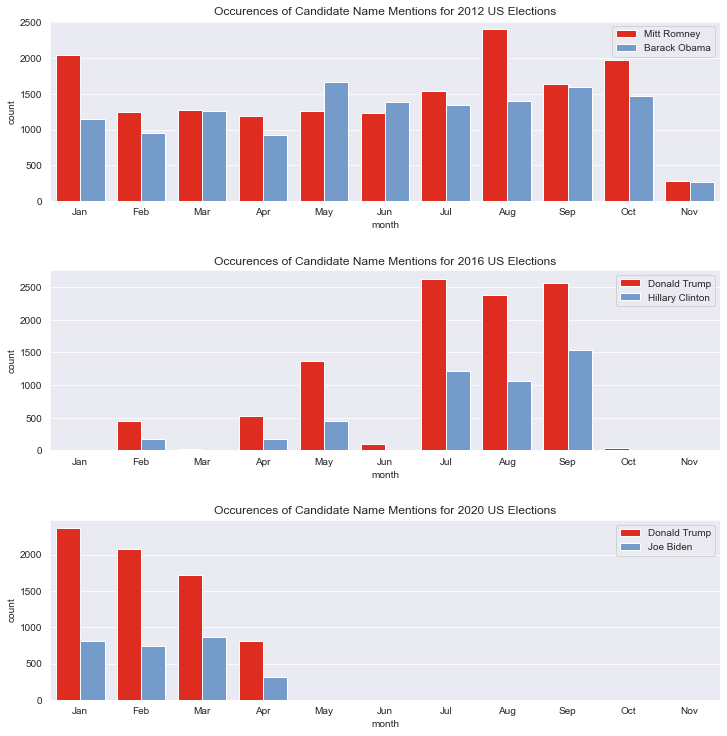

In [15]:
# Plot candidate name mentions distributions
fig, axs = plt.subplots(3,figsize=(10,10))
fig.tight_layout(h_pad=5)

axs[0].set_title("Occurences of Candidate Name Mentions for 2012 US Elections")
sns.countplot(x="month",hue="candidate",data=df_candidates_2012,order=Labels[:11], ax=axs[0], palette=["#fe1100",'#6699d8'])
axs[0].legend(loc='upper right')

axs[1].set_title("Occurences of Candidate Name Mentions for 2016 US Elections")
sns.countplot(x="month",hue="candidate",data=df_candidates_2016,order=Labels[:11], ax=axs[1], palette=["#fe1100",'#6699d8'])
axs[1].legend(loc='upper right')

axs[2].set_title("Occurences of Candidate Name Mentions for 2020 US Elections")
sns.countplot(x="month",hue="candidate",data=df_candidates_2020,order=Labels[:11], ax=axs[2], palette=["#fe1100",'#6699d8'])
axs[2].legend(loc='upper right');

We see in the visualizations above a very interesting trend in which the republican candidates seem to be generally more represented/mentioned in the three elections (without making a distinction between newspapers). It will be part of our analysis to determine whether this may only be some behavior due to a possible unbalanced nature of the quotebank dataset, or if the republican candidate generally gets more media coverage. Although the difference between Obama and Romney remains somewhat limited, the few months we can observe in the 2016 and 2020 elections show a complete disproportionate coverage between Trump and the democratic candidate. 

Here too we can analyse some candidate-related numbers for each year independently of the newspapers in which they were mentioned. This will allow us to already get a more precise metric (in addition to the visualization above) 

In [16]:
# Overall
df1 = df_candidates_2012.groupby(["candidate"]).count()[['Unnamed: 0']]
df2 = df_candidates_2016.groupby(["candidate"]).count()[['Unnamed: 0']]
df3 = df_candidates_2020.groupby(["candidate"]).count()[['Unnamed: 0']]
df_total = merge_dataframes(df1,df2,df3)
df_total.fillna("-",inplace=True)
df_total.rename(columns = {'Unnamed: 0_x':'2012', 'Unnamed: 0_y':'2016','Unnamed: 0':'2020'}, inplace = True)
difference = np.array([df_total.loc['Mitt Romney','2012'] - df_total.loc['Barack Obama','2012'],
        df_total.loc['Donald Trump','2016'] - df_total.loc['Hillary Clinton','2016'], 
        df_total.loc['Donald Trump','2020'] - df_total.loc['Joe Biden','2020']])
df_total.loc[len(df_total)] = difference
df_total = df_total.rename({5: "Difference (Rep-Dem)"})

# Monthly based
df1_month = df_candidates_2012.groupby(["month","candidate"]).count()[['Unnamed: 0']]
df2_month = df_candidates_2016.groupby(["month","candidate"]).count()[['Unnamed: 0']]
df3_month = df_candidates_2020.groupby(["month","candidate"]).count()[['Unnamed: 0']]
df_total_month = merge_dataframes(df1_month,df2_month,df3_month)
df_total_month = df_total_month.reindex(axis='index', level=0, labels=Labels[:11], fill_value=0)
df_total_month.unstack().swaplevel(0, 1, axis=1).sort_index(axis=1)
df_total_month.fillna("-",inplace=True)
df_total_month.rename(columns = {'Unnamed: 0_x':'2012', 'Unnamed: 0_y':'2016','Unnamed: 0':'2020'}, inplace = True)

In [17]:
df_total

,2012,2016,2020
candidate,,,
Barack Obama,13403.0,-,-
Donald Trump,-,10092.0,6976.0
Hillary Clinton,-,4632.0,-
Joe Biden,-,-,2733.0
Mitt Romney,16098.0,-,-
Difference (Rep-Dem),2695.0,5460.0,4243.0


In [18]:
df_total_month

2012    2016    2020
month candidate                              
Jan   Barack Obama     1147.0       -       -
      Donald Trump          -     9.0  2362.0
      Hillary Clinton       -     6.0       -
      Joe Biden             -       -   807.0
      Mitt Romney      2044.0       -       -
Feb   Barack Obama      952.0       -       -
      Donald Trump          -   443.0  2083.0
      Hillary Clinton       -   177.0       -
      Joe Biden             -       -   745.0
      Mitt Romney      1242.0       -       -
Mar   Barack Obama     1265.0       -       -
      Donald Trump          -    28.0  1722.0
      Hillary Clinton       -     2.0       -
      Joe Biden             -       -   872.0
      Mitt Romney      1278.0       -       -
Apr   Barack Obama      925.0       -       -
      Donald Trump          -   532.0   809.0
      Hillary Clinton       -   169.0       -
      Joe Biden             -       -   309.0
      Mitt Romney      1193.0       -       -
May   Barack Obama     1661.0       -       -
      Donald Trump          -  1368.0       -
      Hillary Clinton       -   450.0       -
      Mitt Romney      1263.0       -       -
Jun   Barack Obama     1384.0       -       -
      Donald Trump          -    96.0       -
      Hillary Clinton       -     8.0       -
      Mitt Romney      1235.0       -       -
Jul   Barack Obama     1350.0       -       -
      Donald Trump          -  2627.0       -
      Hillary Clinton       -  1210.0       -
      Mitt Romney      1545.0       -       -
Aug   Barack Obama     1404.0       -       -
      Donald Trump          -  2384.0       -
      Hillary Clinton       -  1062.0       -
      Mitt Romney      2402.0       -       -
Sep   Barack Obama     1590.0       -       -
      Donald Trump          -  2572.0       -
      Hillary Clinton       -  1533.0       -
      Mitt Romney      1633.0       -       -
Oct   Barack Obama     1466.0       -       -
      Donald Trump          -    32.0       -
      Hillary Clinton       -    12.0       -
      Mitt Romney      1978.0       -       -
Nov   Barack Obama      259.0       -       -
      Donald Trump          -     1.0       -
      Hillary Clinton       -     3.0       -
      Mitt Romney       285.0       -       -

It is interesting to note from the tables above the overall difference between the republican and the democrat candidate over the span of the three elections. In 2012, we had overall 2695 more quotation referring to Mitt Romney (Republican) than Barack Obama (Democrat). This number is then increased almost two-fold for the 2016 and 2020 elections. Even considering all the missing data in our set for these two years, this is a notable difference that may be even more drastic with a full dataset. This raises the question whether the arrival of Donald Trump as a presidential candidate motivated this increase in media coverage difference between republican and democrat candidate.

## Part 4: Quandidate Name Distribution Per Newspaper


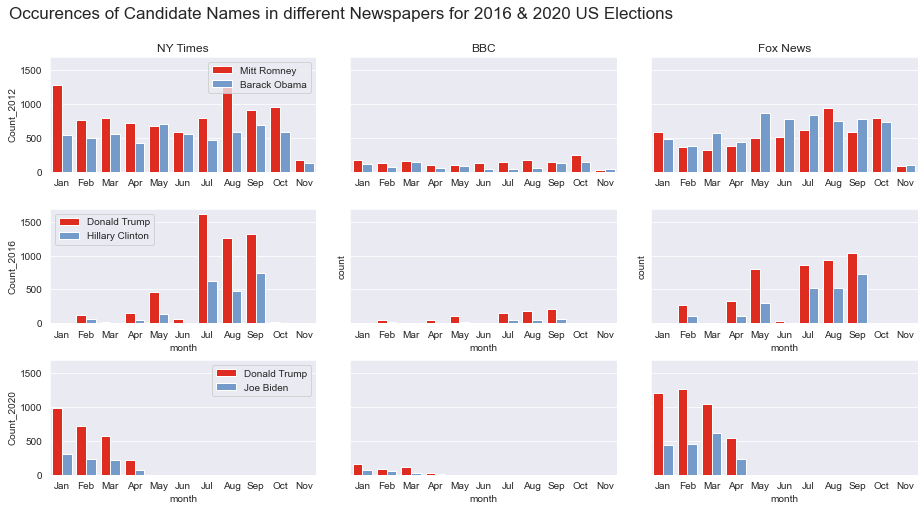

In [20]:
# Plot candidate name mentions distributions
fig, axs = plt.subplots(3,3,figsize=(13,7), sharey=True)

fig.tight_layout(pad=2)
plt.subplots_adjust(top=0.9)
plt.suptitle("Occurences of Candidate Names in different Newspapers for 2016 & 2020 US Elections", x=0, y=1, 
             horizontalalignment='left', verticalalignment='top', fontsize = 17)

axs[0,0].set_title("NY Times")
axs[0,1].set_title("BBC")
axs[0,2].set_title("Fox News")

sns.countplot(x="month",hue="candidate",data=df_candidates_2012[df_candidates_2012.type=="NY Times"],
              order=Labels[:11], ax=axs[0,0], palette=["#fe1100",'#6699d8'])
sns.countplot(x="month",hue="candidate",data=df_candidates_2012[df_candidates_2012.type=="BBC"],
              order=Labels[:11], ax=axs[0,1], palette=["#fe1100",'#6699d8'])
sns.countplot(x="month",hue="candidate",data=df_candidates_2012[df_candidates_2012.type=="Fox News"],
              order=Labels[:11], ax=axs[0,2], palette=["#fe1100",'#6699d8'])

axs[0,0].set(ylabel="Count_2012")
axs[0,0].legend(loc='upper right')
axs[0,0].set(xlabel=None)
axs[0,1].set(xlabel=None)
axs[0,1].set(ylabel=None)
axs[0,2].set(xlabel=None)
axs[0,2].set(ylabel=None)
axs[0,1].legend([],[], frameon=False)
axs[0,2].legend([],[], frameon=False)

sns.countplot(x="month",hue="candidate",data=df_candidates_2016[df_candidates_2016.type=="NY Times"],
              order=Labels[:11], ax=axs[1,0], palette=["#fe1100",'#6699d8'])
sns.countplot(x="month",hue="candidate",data=df_candidates_2016[df_candidates_2016.type=="BBC"],
              order=Labels[:11], ax=axs[1,1], palette=["#fe1100",'#6699d8'])
sns.countplot(x="month",hue="candidate",data=df_candidates_2016[df_candidates_2016.type=="Fox News"],
              order=Labels[:11], ax=axs[1,2], palette=["#fe1100",'#6699d8'])

axs[1,0].set(ylabel="Count_2016")
axs[1,0].legend(loc='upper left')
axs[1,1].legend([],[], frameon=False)
axs[1,2].legend([],[], frameon=False)

sns.countplot(x="month",hue="candidate",data=df_candidates_2020[df_candidates_2020.type=="NY Times"],
              order=Labels[:11], ax=axs[2,0], palette=["#fe1100",'#6699d8'])
sns.countplot(x="month",hue="candidate",data=df_candidates_2020[df_candidates_2020.type=="BBC"],
              order=Labels[:11], ax=axs[2,1], palette=["#fe1100",'#6699d8'])
sns.countplot(x="month",hue="candidate",data=df_candidates_2020[df_candidates_2020.type=="Fox News"],
              order=Labels[:11], ax=axs[2,2], palette=["#fe1100",'#6699d8'])
axs[2,0].legend(loc='upper right');
axs[2,0].set(ylabel="Count_2020")
axs[2,1].set(ylabel=None)
axs[2,2].set(ylabel=None)
axs[2,1].legend([],[], frameon=False)
axs[2,2].legend([],[], frameon=False);


In [21]:
df_cand_2012 = df_candidates_2012.groupby(["month","candidate","type"]).count()[['Unnamed: 0']]
df_cand_2012.rename(columns = {'Unnamed: 0':'count'}, inplace = True)
df_cand_2016 = df_candidates_2016.groupby(["month","candidate","type"]).count()[['Unnamed: 0']]
df_cand_2016.rename(columns = {'Unnamed: 0':'count'}, inplace = True)
df_cand_2020 = df_candidates_2020.groupby(["month","candidate","type"]).count()[['Unnamed: 0']]
df_cand_2020.rename(columns = {'Unnamed: 0':'count'}, inplace = True)
df_cand_2012 = df_cand_2012.reindex(axis='index', level=0, labels=Labels[:11], fill_value=0)
df_cand_2016 = df_cand_2016.reindex(axis='index', level=0, labels=Labels[:11], fill_value=0)
df_cand_2020 = df_cand_2020.reindex(axis='index', level=0, labels=Labels[:11], fill_value=0)
df_cand_2012 = df_cand_2012.reset_index(level=['type'])
df_cand_2016 = df_cand_2016.reset_index(level=['type'])
df_cand_2020 = df_cand_2020.reset_index(level=['type'])

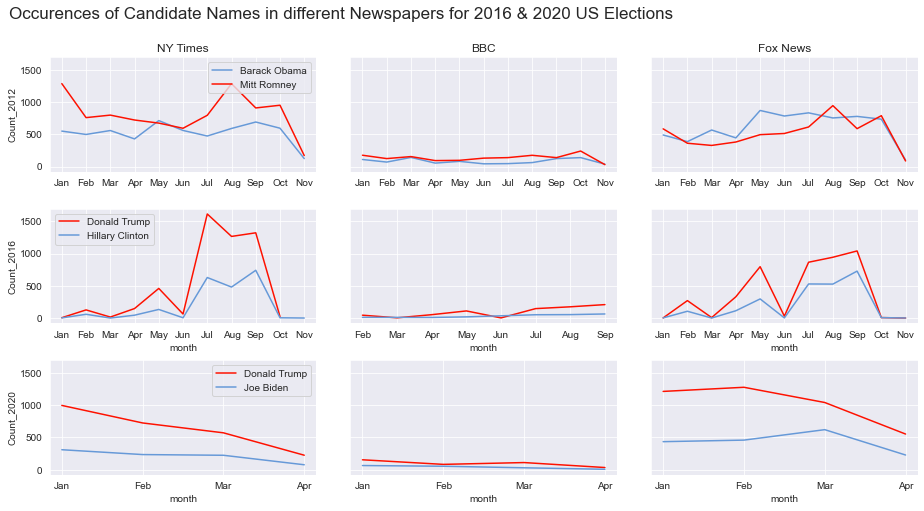

In [22]:
# Plot candidate name mentions distributions
fig, axs = plt.subplots(3,3,figsize=(13,7), sharey=True)

fig.tight_layout(pad=2)
plt.subplots_adjust(top=0.9)
plt.suptitle("Occurences of Candidate Names in different Newspapers for 2016 & 2020 US Elections", x=0, y=1, 
             horizontalalignment='left', verticalalignment='top', fontsize = 17)

sns.lineplot(data=df_cand_2012[df_cand_2012['type']=='NY Times'], x="month", y="count",
             hue="candidate", ax=axs[0,0], palette=["#6699d8",'#fe1100'])
sns.lineplot(data=df_cand_2012[df_cand_2012['type']=='BBC'], x="month", y="count",
             hue="candidate", ax=axs[0,1], palette=["#6699d8",'#fe1100'])
sns.lineplot(data=df_cand_2012[df_cand_2012['type']=='Fox News'], x="month", y="count",
             hue="candidate", ax=axs[0,2], palette=["#6699d8",'#fe1100'])

axs[0,0].set_title("NY Times")
axs[0,1].set_title("BBC")
axs[0,2].set_title("Fox News")

axs[0,0].set(ylabel="Count_2012")
axs[0,0].legend(loc='upper right')
axs[0,0].set(xlabel=None)
axs[0,1].set(xlabel=None)
axs[0,1].set(ylabel=None)
axs[0,2].set(xlabel=None)
axs[0,2].set(ylabel=None)
axs[0,1].legend([],[], frameon=False)
axs[0,2].legend([],[], frameon=False)

sns.lineplot(data=df_cand_2016[df_cand_2016['type']=='NY Times'], x="month", y="count",
             hue="candidate", ax=axs[1,0], palette=["#fe1100",'#6699d8'])
sns.lineplot(data=df_cand_2016[df_cand_2016['type']=='BBC'], x="month", y="count",
             hue="candidate", ax=axs[1,1], palette=["#fe1100",'#6699d8'])
sns.lineplot(data=df_cand_2016[df_cand_2016['type']=='Fox News'], x="month", y="count",
             hue="candidate", ax=axs[1,2], palette=["#fe1100",'#6699d8'])

axs[1,0].set(ylabel="Count_2016")
axs[1,0].legend(loc='upper left')
axs[1,1].legend([],[], frameon=False)
axs[1,2].legend([],[], frameon=False)

sns.lineplot(data=df_cand_2020[df_cand_2020['type']=='NY Times'], x="month", y="count",
             hue="candidate", ax=axs[2,0], palette=["#fe1100",'#6699d8'])
sns.lineplot(data=df_cand_2020[df_cand_2020['type']=='BBC'], x="month", y="count",
             hue="candidate", ax=axs[2,1], palette=["#fe1100",'#6699d8'])
sns.lineplot(data=df_cand_2020[df_cand_2020['type']=='Fox News'], x="month", y="count",
             hue="candidate", ax=axs[2,2], palette=["#fe1100",'#6699d8'])

axs[2,0].legend(loc='upper right');
axs[2,0].set(ylabel="Count_2020")
axs[2,1].set(ylabel=None)
axs[2,2].set(ylabel=None)
axs[2,1].legend([],[], frameon=False)
axs[2,2].legend([],[], frameon=False);

This visualization offers some very interesting insights relating to the observation previously noted in which the republican candidate tends to get higher media coverage than the democrat one. We see that this is not necessarily the case for 2012: NYTimes (a notoriously Democrat newspaper) shows stronger media coverage for Mitt Romney however Fox News (a notoriously Republican newspaper) shows slightly higher media coverage for Barack Obama. This is a very interesting behavior that is not apparent when looking only at overall mentions accross all newspapers. 

The only month in 2012 in which Barack Obama was given more NYTimes media coverage was in May. We also see that the highest democratic candidate coverage in the Fox News newspaper was during that same month. Can these peaks be attributed to a particular event? After a quick online search we found that in May 2012, Barack Obama became the first sitting US president to announce support for same-sex marriage. Could these events be related? A more fined grain analysis may reveal correlation between these two events.  

Nevertheless, in 2016 and 2020, the republican candidate always gets more media coverage than the democratic one (could this relate the polemical nature of candidate Donald Trump?)

## Key Takeaways 
* We are missing too much data for 2020: we may have to drop this year. 
* We are missing a decent amount of data for 2016. We may have to augment the data or try to find external sources
* The republican seems to have a higher monthly media coverage except for Fox News covering Barack Obama in 2012.
* The total monthly coverage retrieved on Trump far surpasses the coverage of his opponents in both 2016 and 2020. 
* In 2012, the NY Times (democrat) seemed to have covered the Republican opponent more while Fox News (Republican) seemed to have covered the Democratic Candidate more.
* BBC seems to repeatedly cover the republican candidate more. However, we do not have a large amount of data for BBC. We may consider using an other centrist-labeled newspaper with more quotations in the quotebank. 